# Task 01

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Assignment 5 Dataset')

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

vali_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('train', transform=train_transforms)
test_data = datasets.ImageFolder('test', transform=test_transforms)
vali_data = datasets.ImageFolder('validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
valiloader = torch.utils.data.DataLoader(vali_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [5]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [6]:
features = list(vgg16.classifier.children())[0:0] # Remove All FC Layers
print(features)

[]


In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [0]:
features.extend([nn.Linear(25088, 390)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(390, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, len(class_names))])

In [9]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        pred = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        output = vgg16(inputs)
        loss = criterion(output, labels)
        vali_runing += loss.item()
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    torch.save(vgg16.state_dict(), '/content/vgg16_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [4608/12000 (38%)]	Loss: 0.605277: : 145it [27:24, 11.42s/it]

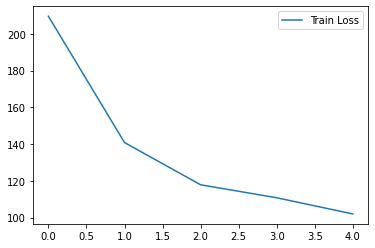

In [15]:
plt.plot(train_loss)
plt.legend(['Train Loss'], loc='upper right')
plt.show()

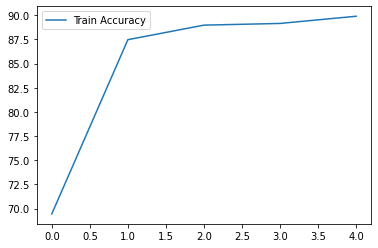

In [16]:
plt.plot(train_acc)
plt.legend(['Train Accuracy'], loc='upper left')
plt.show()

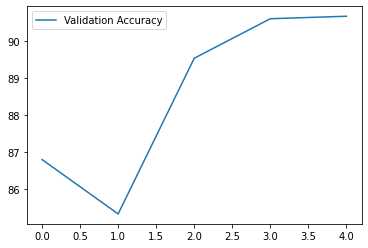

In [17]:
plt.plot(vali_acc)
plt.legend(['Validation Accuracy'], loc='upper left')
plt.show()

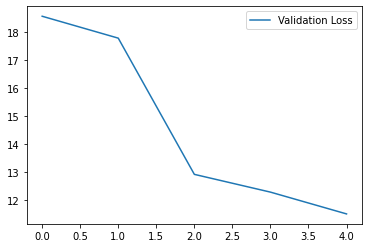

In [28]:
plt.plot(vali_loss)
plt.legend(['Validation Loss'], loc='upper right')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

pred_test = []
labels_test = []
with torch.no_grad():
  for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    pred_test += list(pred.cpu().numpy())
    labels_test += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_test, labels_test)
print(conf_matrix)

[[562   8]
 [ 53 877]]


In [23]:
pred_vali = []
labels_vali = []
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)

[[524  58]
 [ 91 827]]


In [24]:
pred_train = []
labels_train = []
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    pred_train += list(pred.cpu().numpy())
    labels_train += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_train, labels_train)
print(conf_matrix)

[[4335  492]
 [ 584 6543]]


In [21]:
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    total += labels.size(0)
    correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 91 %


In [0]:
from sklearn.metrics import f1_score
f1_score = f1_score(labels.cpu().numpy(), pred.cpu().numpy(), average='weighted')
print(f"F1 Score: {f1_score}")

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images, labels = Variable(images.to(device)), Variable(labels.to(device))
# show images
output = vgg16(images)
pred = torch.argmax(output, 1)
print(f'Predicted : {pred}')
print(f'Original : {labels}')

In [13]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
for param in resnet18.layer1.parameters():
    param.require_grad = False
for param in resnet18.layer2.parameters():
    param.require_grad = False
for param in resnet18.layer3.parameters():
    param.require_grad = False
for param in resnet18.layer4.parameters():
    param.require_grad = False
for param in resnet18.avgpool.parameters():
    param.require_grad = False
for param in resnet18.conv1.parameters():
    param.require_grad = False
for param in resnet18.bn1.parameters():
    param.require_grad = False
for param in resnet18.relu.parameters():
    param.require_grad = False
for param in resnet18.maxpool.parameters():
    param.require_grad = False

In [15]:
features = list(resnet18.fc.children())[0:0] # Remove All FC Layers
print(features)

[]


In [0]:
features.extend([nn.Linear(512, 390)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(390, len(class_names))])

In [17]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [19]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        pred = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        output = resnet18(inputs)
        loss = criterion(output, labels)
        vali_runing += loss.item()
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    torch.save(vgg16.state_dict(), '/content/resnet19_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.200592: : 375it [06:05,  1.02it/s]
Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.263731: : 375it [05:42,  1.10it/s]
Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.221978: : 375it [05:49,  1.07it/s]
Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.139303: : 375it [05:54,  1.06it/s]
Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.149188: : 375it [05:43,  1.09it/s]


Finished Training


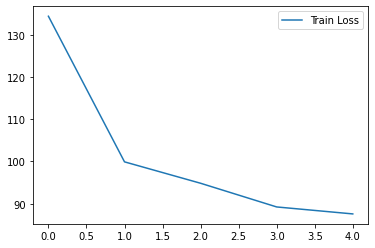

In [20]:
plt.plot(train_loss)
plt.legend(['Train Loss'], loc='upper right')
plt.show()

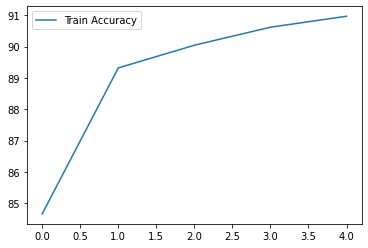

In [21]:
plt.plot(train_acc)
plt.legend(['Train Accuracy'], loc='upper left')
plt.show()

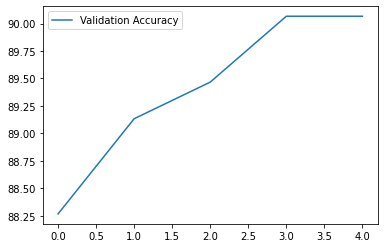

In [22]:
plt.plot(vali_acc)
plt.legend(['Validation Accuracy'], loc='upper left')
plt.show()

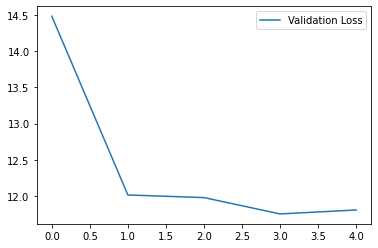

In [23]:
plt.plot(vali_loss)
plt.legend(['Validation Loss'], loc='upper right')
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix

pred_test = []
labels_test = []
with torch.no_grad():
  for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    pred_test += list(pred.cpu().numpy())
    labels_test += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_test, labels_test)
print(conf_matrix)

[[579  24]
 [ 36 861]]


In [25]:
pred_vali = []
labels_vali = []
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)

[[549  82]
 [ 66 803]]


In [26]:
pred_train = []
labels_train = []
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    pred_train += list(pred.cpu().numpy())
    labels_train += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_train, labels_train)
print(conf_matrix)

[[4366  483]
 [ 553 6598]]


In [27]:
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    total += labels.size(0)
    correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 90 %


In [29]:
from sklearn.metrics import f1_score
f1_score = f1_score(labels.cpu().numpy(), pred.cpu().numpy(), average='weighted')
print(f"F1 Score: {f1_score}")

F1 Score: 0.9069230769230769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


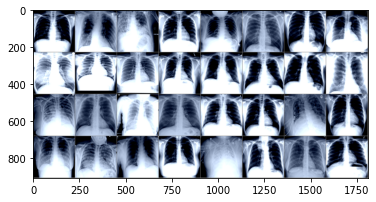

Predicted : tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
Original : tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')


In [42]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images, labels = Variable(images.to(device)), Variable(labels.to(device))
# show images
output = resnet18(images)
pred = torch.argmax(output, 1)
print(f'Predicted : {pred}')
print(f'Original : {labels}')

# Task 02

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features)

In [0]:
features = list(vgg16.classifier.children())[0:0] # Remove All FC Layers
print(features)

In [0]:
features.extend([nn.Linear(25088, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        pred = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        output = vgg16(inputs)
        loss = criterion(output, labels)
        vali_runing += loss.item()
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    torch.save(vgg16.state_dict(), '/content/vgg16_entire.pth')

print('Finished Training')

In [0]:
plt.plot(train_loss)
plt.legend(['Train Loss'], loc='upper right')
plt.show()

In [0]:
plt.plot(train_acc)
plt.legend(['Train Accuracy'], loc='upper left')
plt.show()

In [0]:
plt.plot(vali_acc)
plt.legend(['Validation Accuracy'], loc='upper left')
plt.show()

In [0]:
plt.plot(vali_loss)
plt.legend(['Validation Loss'], loc='upper right')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix

pred_test = []
labels_test = []
with torch.no_grad():
  for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    pred_test += list(pred.cpu().numpy())
    labels_test += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_test, labels_test)
print(conf_matrix)

In [0]:
pred_vali = []
labels_vali = []
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)

In [0]:
pred_train = []
labels_train = []
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    pred_train += list(pred.cpu().numpy())
    labels_train += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_train, labels_train)
print(conf_matrix)

In [0]:
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
    output = vgg16(inputs)
    pred = torch.argmax(output, 1)
    total += labels.size(0)
    correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

In [0]:
from sklearn.metrics import f1_score
f1_score = f1_score(labels.cpu().numpy(), pred.cpu().numpy(), average='weighted')
print(f"F1 Score: {f1_score}")

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images, labels = Variable(images.to(device)), Variable(labels.to(device))
# show images
output = vgg16(images)
pred = torch.argmax(output, 1)
print(f'Predicted : {pred}')
print(f'Original : {labels}')

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

In [0]:
features = list(resnet18.fc.children())[0:0] # Remove All FC Layers
print(features)

In [0]:
features.extend([nn.Linear(512, 390)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(390, len(class_names))])

In [0]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

In [0]:
Epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        pred = torch.argmax(outputs, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

        output = resnet18(inputs)
        loss = criterion(output, labels)
        vali_runing += loss.item()
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (pred.cpu().numpy() == labels.cpu().numpy()).sum().item()

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    torch.save(vgg16.state_dict(), '/content/resnet18_entire.pth')

print('Finished Training')

In [0]:
plt.plot(train_loss)
plt.legend(['Train Loss'], loc='upper right')
plt.show()

In [0]:
plt.plot(train_acc)
plt.legend(['Train Accuracy'], loc='upper left')
plt.show()

In [0]:
plt.plot(vali_acc)
plt.legend(['Validation Accuracy'], loc='upper left')
plt.show()

In [0]:
plt.plot(vali_acc)
plt.legend(['Validation Accuracy'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix

pred_test = []
labels_test = []
with torch.no_grad():
  for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    pred_test += list(pred.cpu().numpy())
    labels_test += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_test, labels_test)
print(conf_matrix)

In [0]:
pred_vali = []
labels_vali = []
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)

In [0]:
pred_train = []
labels_train = []
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    output = resnet18(inputs)
    pred = torch.argmax(output, 1)
    pred_train += list(pred.cpu().numpy())
    labels_train += list(labels.cpu().numpy())

conf_matrix = confusion_matrix(pred_train, labels_train)
print(conf_matrix)

In [0]:
from sklearn.metrics import f1_score
f1_score = f1_score(labels.cpu().numpy(), pred.cpu().numpy(), average='weighted')
print(f"F1 Score: {f1_score}")

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images, labels = Variable(images.to(device)), Variable(labels.to(device))
# show images
output =resnet18(images)
pred = torch.argmax(output, 1)
print(f'Predicted : {pred}')
print(f'Original : {labels}')